In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt

**Подготовка данных** 

In [2]:
customers_df = pd.read_csv('C:/Users/elnur/Downloads/olist_customers_dataset.csv')
orders_df = pd.read_csv('C:/Users/elnur/Downloads/olist_orders_dataset.csv')
items_df = pd.read_csv('C:/Users/elnur/Downloads/olist_order_items_dataset.csv')

In [3]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])

# Задача 1

- Исследовать датасет и определить, какой вид заказа будет учитываться в retention
  
- Построить месячный retention
  
- Проанализировать, чему равен медианный retention 1-го месяца (т.е. взять retention 1-ого месяца для всех когорт и посчитать по этим числам медиану)
  
- Найти когорту с самым высоким retention на 3-й месяц.
  
- Проиллюстрировать результаты релевантной визуализацией, удобной для восприятия.

In [4]:
#Добавил, к таблице ордерс, столбец с уникальным ID пользователя, и оставил только доставленные заказы 
retenrion_df = orders_df.merge(customers_df[['customer_id', 'customer_unique_id']], on='customer_id').query("order_status == 'delivered'")

**Использовал заказы со статусом delivered**

- **Реальная активация:** Только доставленный заказ означает,
  что клиент действительно получил продукт и испытал полный цикл услуги.
- **Реальная активность:** Это позволяет измерять истинное удержание, а не просто намерение клиента.

In [5]:
#Создал таблицу, с датой первого заказа, для каждого уникального клиента
first_order_date = retenrion_df.groupby('customer_unique_id', as_index=False).order_purchase_timestamp.min()

# Создал столбцы, с первым месяцем и днем, оформления заказа
first_order_date['M'] = first_order_date['order_purchase_timestamp'].dt.month.fillna(0).astype(int)
first_order_date['Y'] = first_order_date['order_purchase_timestamp'].dt.year.fillna(0).astype(int)

In [6]:
#Оставил нужные столбцы
retenrion_df = retenrion_df[['order_id', 'customer_unique_id', 'customer_id', 'order_purchase_timestamp']]

In [7]:
#Убрал null-ы, их было 13. В годах те же самые 13 были нуллами 
first_order_date[first_order_date['M'] == 0].shape[0]
first_order_date = first_order_date[first_order_date['M'] != 0]

In [8]:
#Добавил к основной таблице, месяц и год оформления, первого заказа
retenrion_df = retenrion_df.merge(first_order_date[['M', 'Y', 'customer_unique_id']], on='customer_unique_id')

#Добавил столбец с количеством месяцев прошедших с первого заказа
retenrion_df['months_since_activation'] = (retenrion_df.order_purchase_timestamp.dt.year - retenrion_df.Y)*12 + (retenrion_df.order_purchase_timestamp.dt.month - retenrion_df.M)

In [9]:
retenrion_df['M_Y'] = pd.to_datetime(retenrion_df['Y'].astype(str) + '-' + retenrion_df['M'].astype(str), format='%Y-%m')

In [10]:
retention_matrix = retenrion_df.groupby(['M_Y', 'months_since_activation'], as_index=False).customer_unique_id.nunique()

In [11]:
retention_matrix = retention_matrix.pivot_table(index='M_Y', columns='months_since_activation', values='customer_unique_id')

In [12]:
#В 2016 году, 9 и 12 месяцах было только по 1 доставленному заказу, убираю эти данные так как это аномалии
orders_df.query("(order_purchase_timestamp.dt.year == 2016) & (order_purchase_timestamp.dt.month == 9)") #4 заказа
orders_df.query("(order_purchase_timestamp.dt.year == 2016) & (order_purchase_timestamp.dt.month == 12)") #1 заказ

retention_matrix = retention_matrix.drop(['2016-09', '2016-12'], axis=0)

In [13]:
#Размеры когорт
cohort_sizes = retention_matrix[0]
#Перевел в проценты
retention_matrix = retention_matrix.div(cohort_sizes, axis=0)

In [14]:
retention_matrix

months_since_activation,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
M_Y,,,,,,,,,,,,,,,,,,,,
2016-10-01,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2017-01-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,NaN
2017-02-01,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.003071,0.001229,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN
2017-03-01,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,0.001199,0.001598,0.002397,0.000799,0.001199,NaN,NaN
2017-04-01,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.001773,0.002660,0.000887,0.000443,0.000443,0.000887,0.000887,0.001330,NaN,NaN,NaN
2017-05-01,1.0,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,0.002608,0.002608,0.002608,0.003477,0.002318,0.000290,0.001739,0.002028,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.0,0.005330,0.003465,0.002399,0.002932,0.002132,0.003198,0.001066,0.001866,0.002665,0.002132,0.002932,0.001333,0.002399,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,1.0,0.006902,0.003451,0.002711,0.003451,0.005176,0.002958,0.002711,0.001479,0.001479,0.002465,0.001972,0.001232,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='months_since_activation', ylabel='M_Y'>

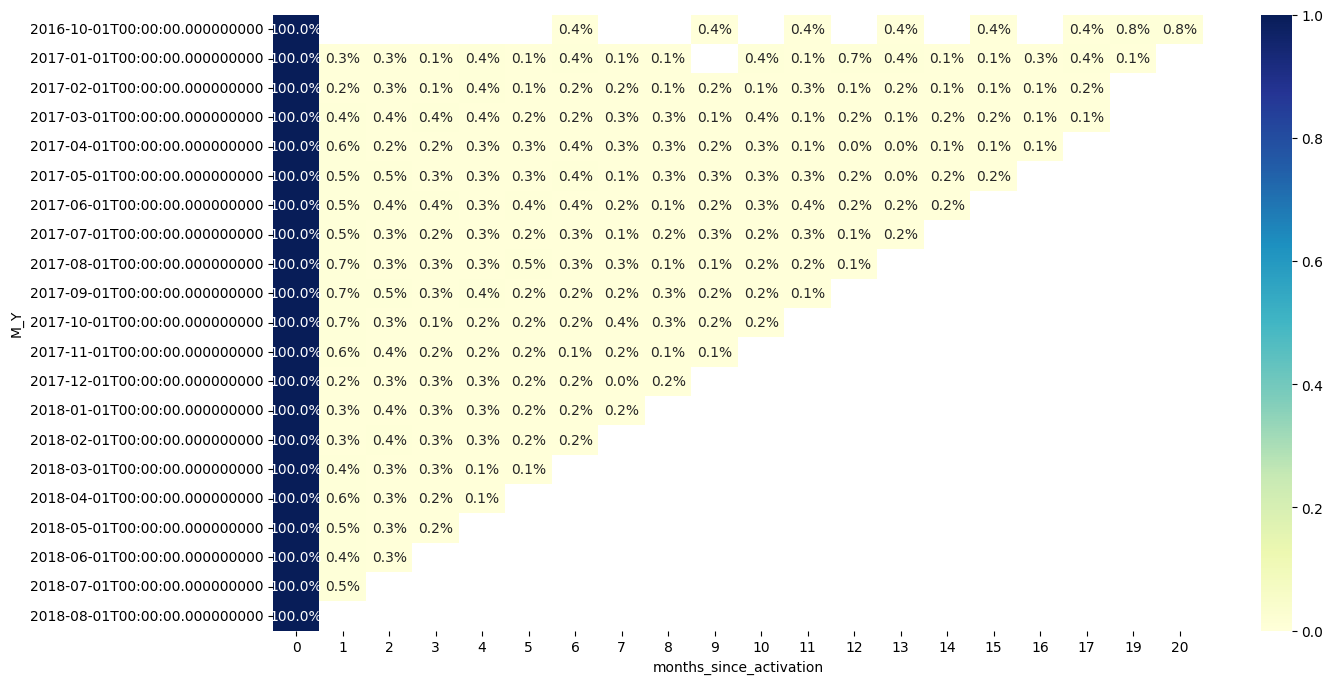

In [15]:
plt.figure(figsize=(15, 8)) 
sns.heatmap(retention_matrix, annot=True, fmt=".1%", cmap="YlGnBu", vmin=0.0, vmax=1.0)

In [16]:
#Медиана первого месяца в процентах
retention_matrix[1].median().round(4)

np.float64(0.0049)

**Медианный retention 1-го месяца равен 0.49%**

In [17]:
retention_matrix[3].max().round(5)

np.float64(0.00428)

In [18]:
#Когорта с самым высоким retention на 3-й месяц
retention_matrix[retention_matrix[3].round(5) == 0.00428]

months_since_activation,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
M_Y,,,,,,,,,,,,,,,,,,,,
2017-06-01,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN


**Когорта с самым высоким retention на 3-й месяц: 2017-06**

# Задача 2

- Оценить наличие product/market fit у данного продукта с помощью когортного анализа, полученного на предыдущем шаге.

- Пояснить свою позицию и сформулировать, на чём маркетплейс должен сконцентрироваться в ближайшее время. Если PMF есть, то в какую сторону лучше развивать продукт дальше? Если PMF нет, то какие причины могут быть у этого?

- Подкрепить свои выводы релевантной визуализацией, удобной для восприятия.

Когортный анализ показывает что 99.5% пользователей уходят после первого месяца(первого заказа), это значит у продукта нету **PMF**

**Проверка по времени доставки, возможно пользователей не устраивает именно это**

In [19]:
orders_delivered = orders_df.query("order_status == 'delivered'")

In [20]:
overall_delivery_time_days = (orders_delivered.order_delivered_customer_date - orders_delivered.order_purchase_timestamp).dt.days

In [21]:
delivery_deviation_days = (orders_delivered.order_estimated_delivery_date - orders_delivered.order_delivered_customer_date).dt.days

<Axes: xlabel='None'>

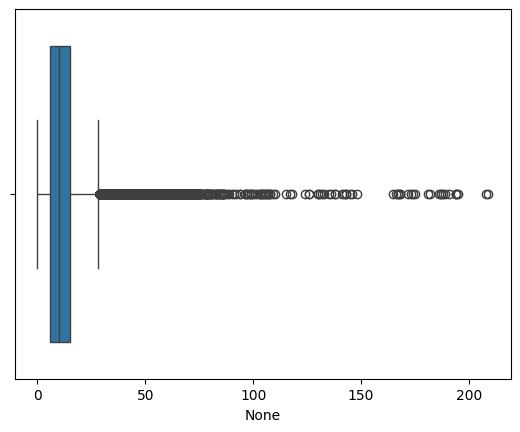

In [22]:
sns.boxplot(x=overall_delivery_time_days)

<Axes: xlabel='None'>

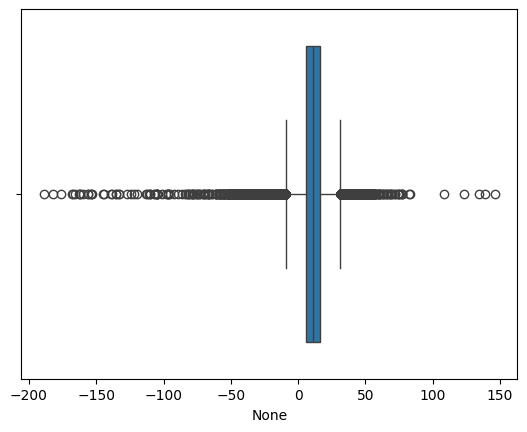

In [23]:
sns.boxplot(x=delivery_deviation_days)

In [24]:
overall_delivery_time_days[overall_delivery_time_days < 20].mean()

np.float64(9.155653093729862)

In [25]:
delivery_deviation_days[delivery_deviation_days < 0].shape[0]

7826

- **85% доставок было сделано меньше чем за 20 дней. В среднем 10 дней**
- **8% доставок опоздали по времени**

**В целом время доставки не является проблемой, так как 92% заказов приезжают вовремя. При этом можно сократить это время для трети заказов, если сможем быстрее подтверждать заказы**

# Задача 3

- Первая метрика должна отражать рост объёма продаж маркетплейса.
- Вторая — показывать объем аудитории, которой продукт доставляет ценность.
- Третья — отражать заинтересованность новых клиентов в продукте (даже если вы не можете посчитать ее на имеющихся у вас данных).
- Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.
- Пятая — отражать денежное выражение вовлеченности клиента.

**Первой метрикой будет общая выручка за месяц**

In [26]:
orders_approved = orders_df[orders_df.order_approved_at.notna()]

In [27]:
orders_approved_cut = orders_approved[['order_id', 'order_approved_at']]

In [28]:
orders_approved_cut = orders_approved_cut.merge(items_df.groupby('order_id', as_index=False).price.sum(), on='order_id', how='left')

In [29]:
orders_approved_cut['month'] = orders_approved_cut.order_approved_at.dt.to_period('M')

In [30]:
revenue_per_month = orders_approved_cut.groupby('month', as_index=False).price.sum()

In [31]:
revenue_per_month = revenue_per_month.drop([0, 2, 23])

<Axes: >

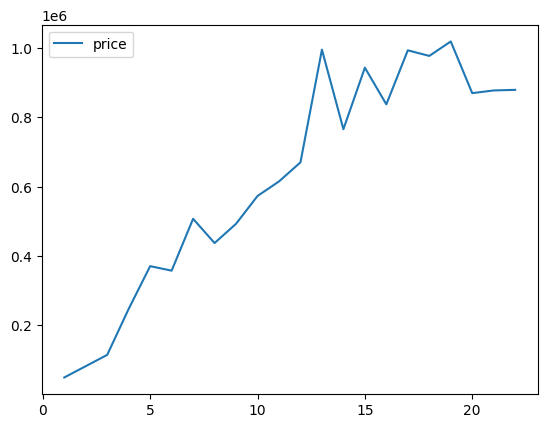

In [32]:
revenue_per_month.plot()

**Второй метрикой будет MAU за последние 30 дней**

In [33]:
monthly_active_users = orders_approved.merge(customers_df[['customer_unique_id', 'customer_id']], on='customer_id')

In [34]:
latest_time = orders_approved.order_approved_at.max()

In [35]:
monthly_active_users['time'] = (latest_time - monthly_active_users.order_approved_at).dt.days

In [36]:
monthly_active_users = monthly_active_users[monthly_active_users['time'] < 31]


In [37]:
monthly_active_users.customer_unique_id.nunique()

5688

**MAU за последние 30 дней = 5688**

**В качестве третьей метрики я бы предложил конверсию в покупки. Для ее расчета необходимы данные по регистрациям**

**В качестве четвертой метрики я выбрал частоту покупок. Она отражает вовлеченность клиентов, так как показывает, как часто они возвращаются для совершения повторных заказов.**

In [38]:
so = orders_approved.merge(customers_df[['customer_id', 'customer_unique_id']], on='customer_id')

In [39]:
so['month'] = so.order_approved_at.dt.to_period('M')

In [40]:
so = so.groupby('month').agg({'customer_unique_id': 'nunique', 'order_id': 'count'})


In [41]:
so['mmm'] = so['order_id'] / so['customer_unique_id']

<Axes: xlabel='month'>

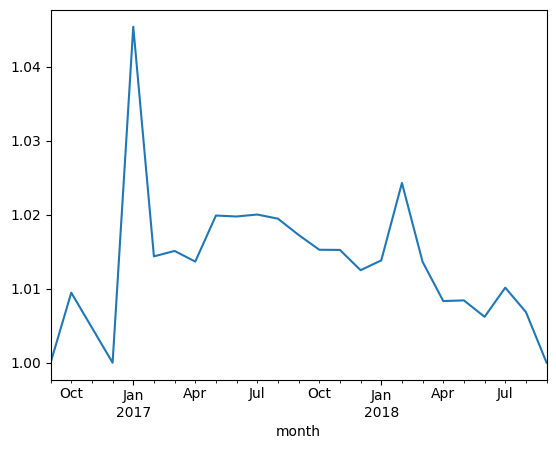

In [42]:
so['mmm'].plot()

**В качестве пятой метрики будет Средний чек**

In [43]:
aov_df = orders_approved.merge(items_df.groupby('order_id', as_index=False).price.sum(), on='order_id')

In [44]:
aov_df['month'] = aov_df.order_approved_at.dt.to_period('M')

In [45]:
aov_df = aov_df.groupby('month').agg({'price': 'sum', 'order_id': 'count'})

aov_df = aov_df.drop(['2016-09', '2016-12'], axis=0)

In [46]:
aov_df['aov'] = aov_df.price / aov_df.order_id

<Axes: xlabel='month'>

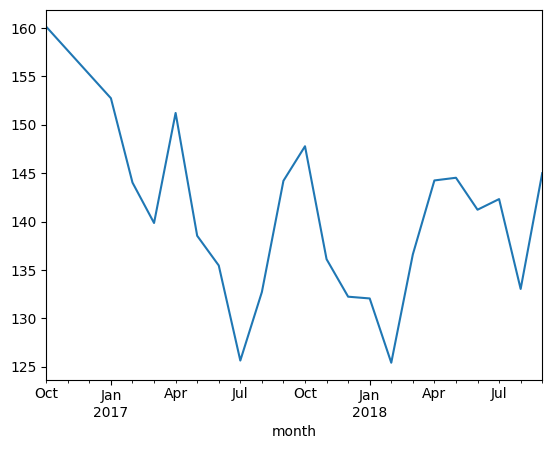

In [47]:
aov_df['aov'].plot()

# Задача 4

In [90]:
june_data = orders_df[orders_df['order_purchase_timestamp'].dt.to_period('M') >= '2017-06']

In [91]:
#Количество отмененных заказов (16)
june_data.query("order_status == 'canceled'").shape[0]

499

**Impact первой гипотезы 4**

In [92]:
june_data_late = june_data[(june_data['order_delivered_customer_date'] - june_data['order_estimated_delivery_date']).dt.total_seconds() > 0].copy()

In [93]:
june_data_late['delay_time'] = june_data['order_delivered_customer_date'] - june_data['order_estimated_delivery_date']

In [94]:
june_data_late['loading_time'] = june_data['order_delivered_carrier_date'] - june_data['order_approved_at']

In [95]:
june_data_late = june_data_late[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'delay_time', 'loading_time']]

In [96]:
#Оставил только те случаи задержки, в которых время на отгрузку превышало время опоздания. (56)
((june_data_late['loading_time'] - june_data_late['delay_time']).dt.total_seconds() > 0).sum()

np.int64(2812)

**Impact второй гипотезы 6**

In [98]:
june_data = june_data.merge(customers_df[['customer_id', 'customer_unique_id']], on='customer_id')

In [101]:
customer_orders_count = june_data.groupby('customer_unique_id').size()

In [105]:
one_time_customers = customer_orders_count[customer_orders_count == 1].count()
one_time_customers * 0.0049

np.float64(404.53909999999996)

**Impact третьей гипотезы 4**

ICE 1 = 4 * 8 * 6 = 192

ICE 2 = 6 * 10 * 4 = 240

ICE 3 = 4 * 5 * 9 = 180 

**Выбираем 2 гипотезу**

Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. 

# Задача 5

Целевой метрикой для данной гипотезы был выбран Retention Rate. Эта метрика напрямую отражает, возвращаются ли клиенты за повторными заказами, что является главной целью гипотезы

Прокси-метрикой была выбрана доля заказов, доставленных вовремя. Улучшение этого показателя станет ранним сигналом того, что наша гипотеза работает и что это может привести к росту Retention Rate в будущем.

В качестве метрики-Guardrail был выбран коэффициент возврата товара или процент негативных отзывов. Эта метрика необходима, чтобы убедиться, что ускорение процесса отгрузки не привело к ухудшению качества обслуживания или продукта.

# Задача 6

1. **Формализация проблемы**
- У маркетплейса отсутствует **Product/Market Fit**. Мы это поняли, потому что **99,5%** клиентов не совершают повторные покупки в первый месяц.

2. **Ключевые выводы**. Основная проблема оттока клиентов не определена, но мы можем улучшить продукт и повысить лояльность, сократив время на отгрузку заказа.

- Низкое удержание клиентов. Главная проблема — это практически полное отсутствие удержания: 99% клиентов не делают повторных заказов. Это указывает на то, что первый опыт клиента не соответствует ожиданиям.
  
- Проблема с логистикой. Анализ данных показал, что всего 3% заказов доставляются с задержкой, но в этих случаях время на отгрузку превышает время задержки. Устранив эту проблему, мы сделаем первый шаг к улучшению продукта и повышению лояльности.

3. **Рекомендации по продукту**
- Улучшить процесс отгрузки заказов. Сосредоточьтесь на сокращении времени от одобрения до передачи заказа в доставку. Это напрямую повлияет на скорость доставки и удовлетворенность клиентов.
- Фокусироваться на вовлеченности. В долгосрочной перспективе, вместо погони за новыми клиентами, нужно инвестировать в повышение частоты покупок и среднего чека.